# <center>Welcome to oLIMpus Tutorial #2!</center>
### <center>By S. Libanore</center>
oLIMpus is based on a fully analytical effective model, and it allows to produce and study LIM auto- and cross- power spectra durning the EoR. 

Our work builds on the 21-cm effective model presented in Zeus21 (Munoz 2023), which is contained as a submodule in our package.

#### In this notebook you will learn how to...
- create mock coeval boxes 
- create lightcones 

#### Available quantites:
- $\delta$ density
- SFRD (cell-by-cell computation)
- $\rho_L$ luminosity density (cell-by-cell computation)
- $x_{\rm HI}$ field (cell-by-cell computation)
- $T_{21}$ brightness temperature 
- $I_\nu$ star-forming line intensity (analytical or cell-by-cell computation); we generically label them as "LIM"

## General definitions

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import os 
import pickle

Set the fiducial inputs based on the **analysis.py** module and run oLIMpus to store in a class all the properties for the line and for the 21cm correlations.


To get familiar with it, check Tutorial #1!

In [2]:
import oLIMpus.analysis as a 

# CLASS object 
ClassyC = a.runclass(a.Cosmo_Parameters_Input(**a.CosmoParams_input_fid))

# oLIMpus object containing 21cm and OIII properties
OIII_model = a.run_oLIMpus('OIII',LINE_MODEL = 'Yang24', _R = 1., shot_noise= True, quadratic_lognormal=True, astromodel=0, ZMIN=5., RSD_MODE=1)

/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:29: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:31: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)


Import the relevant functions from the **maps_LIM** module.

oLIMpus provides three ways to produce mock coeval boxes:

#### CoevalBox_LIM_analytical
Relies on the analytical power spectra computed either from cosmology or using our formalism.
Use it for:
- density $\leftrightarrow P_m(k,z)$
- star-forming line intensity (with / without shot noise, with / without RSD) $\leftrightarrow P_\nu(k,z),\, {\rm RSD}(k,z), P_{\rm shot}(z)$

All outputs can be smoothed over the input $R_0$ using a real space top hat window function. 

#### CoevalBox_percell
Computes density-weighted quantities based on the EPS formalism in Eulerian space. 
Use it for:
- density $\leftrightarrow P_m(k,z)$
- SFRD $\to {\rm SFRD}(\vec{x},z) = (1+\delta(\vec{x},z))\int dM_h dn/dM_h C_{\rm EPS}\dot{M}_*(M_h)$
- luminosity density $\to {\rho}_L(\vec{x},z) = (1+\delta(\vec{x},z))\int dM_h dn/dM_h C_{\rm EPS}L(M_h)$
- LIM $\to I_\nu(\vec{x},z)\propto\bar{I}_\nu(z)\rho_L(\vec{x},z)/\bar{\rho}_L$ 

#### CoevalBox_T21reionization
Inherited from Zeus21, computes the $T_{21}(\vec{x},z)$ brightness temperature based on the effective analytical model. 

Computes the ionization field $x_{\rm HII}(\vec{x},z)$ cell-by-cell based on barrier crossing formalism, transforms it to $x_{\rm HI}$ and use it to produce the bubble field and scale $T_{21}(\vec{x},z)$ during the EoR.  
Use it for:
- $x_{HI}(\vec{x},z)$
- $T_{21}(\vec{x},z)$

A fully analytical computation of the bubble field will be provided in next releases.

In [3]:
from oLIMpus import CoevalBox_T21reionization, CoevalBox_percell, CoevalBox_LIM_analytical, get_reio_field
from oLIMpus import eor_colour, LIM_colour_1

## Produce mock coeval boxes

The following function computes the coeval boxes for the input quantity. 
Its inputs are:
- z = redshift value
- Lbox = side of the box in Mpc
- Nbox = number of cells per side
- line model = the class containing the oLIMpus outputs for line and 21cm
- reionization_map_partial, ion_frac_withpartial = classes containing the ionization and bubble fields; they are computed for all z, hence it is recommended to run them outside the class to avoid redundancy that makes everything much longer
- smooth: if True, the box is smoothed over the R value stored in the oLIMpus class (only for LIM maps)
- shot noise: if True, add shot noise (only for LIM maps) 
- ClassyC = CLASS output
- RSD = which RSD to use, 0 is without RSD while 1 is mu = 0.6, i.e. spherically averaged (both on LIM and 21-cm)
- seed = random seed
- extralabel = string to be included in the output file more than the default ones
- save_and_import = whether to save the outputs (note that storing requires a lot of space); if previous runs were store, this flag allows to import their outputs, to fasten the computation

In [4]:
def get_boxes(which_box, z, Lbox, Nbox, line_model, reionization_map_partial, ion_frac_withpartial, smooth, shot_noise, ClassyC, RSD, seed=1605, extralabel='', save_and_import=True):

    if save_and_import:

        # folder and file name to store the box
        folder = './boxes_' + str(Lbox) + ',' + str(Nbox)
        if not os.path.exists(folder):
            os.makedirs(folder)
        if which_box == 'LIM':
            filename_all = folder + '/' + which_box + '_' + line_model.LP.LINE + '_z' + str(round(z,1))+ extralabel + '.pkl'    
        else:
            filename_all = folder + '/' + which_box + '_z' + str(round(z,1))+ extralabel + '.pkl'

        # import the box if previously run
        if os.path.exists(filename_all):
            with open(filename_all, 'rb') as handle:
                box = pickle.load(handle)

    # run oLIMpus 
    else:
    
        if which_box == 'density' or which_box == 'LIM':
            all_boxes = CoevalBox_LIM_analytical(line_model.LIM_coeff,line_model.LIM_corr,line_model.LIM_pk,line_model.LP,z,line_model.LP._R,Lbox,Nbox, RSD=RSD, get_density_box=True)
            if which_box == 'density':
                box = all_boxes.density_box
            else:
                if smooth:
                    if shot_noise:
                        box = all_boxes.Inu_box_smooth
                    else:
                        box = all_boxes.Inu_box_noiseless_smooth
                else:
                    if shot_noise:
                        box = all_boxes.Inu_box
                    else:
                        box = all_boxes.Inu_box_noiseless

        elif which_box == 'T21' or which_box == 'xHI':
            # reionization library, create bubble field
            if reionization_map_partial is None:
                reionization_map_partial, ion_frac_withpartial = get_reio_field(line_model.zeus_coeff, line_model.zeus_corr, line_model.AP, line_model.CP, ClassyC, line_model.HMFcl, Lbox, Nbox, seed, mass_weighted_xHII=True,one_slice=False)
        
            all_boxes = CoevalBox_T21reionization(line_model.zeus_coeff, line_model.zeus_pk,z, reionization_map_partial, ion_frac_withpartial, Lbox,Nbox, seed=seed)
            if which_box == 'T21':
                box = all_boxes.T21_map
            else:
                box = all_boxes.xH_box

        elif which_box == 'SFRD' or which_box == 'rhoL':
            all_boxes = CoevalBox_percell(line_model.LIM_coeff,line_model.LIM_corr,line_model.LIM_pk,line_model.zeus_coeff, line_model.LP,line_model.AP,line_model.CP,line_model.HMFcl,z,line_model.LP._R,Lbox,Nbox)
            if which_box == 'SFRD':
                box = all_boxes.SFRD_box
            else:
                if smooth:
                    box = all_boxes.rhoL_box_smooth
                else:
                    box = all_boxes.rhoL_box
        else:
            print('Check input box.')
            return -1

        # save the box if required
        if save_and_import:
            with open(filename_all, 'wb') as handle:
                pickle.dump(box,handle)

    return box


#### Example: plot density, SFRD, $x_{\rm HI}$, $T_{21}$, $I_{\rm OIII}$

To produce the plot you need to set the size of the box $L_{\rm box}$ and the number of cells $N_{\rm box}$. The largest scale accessed in the box is $k_{\rm min}=2\pi/L_{\rm box},$ while the smallest is $k_{\rm max}=2\pi N_{\rm box}/L_{\rm box}.$ Remember that the computational power of the run depends on $N_{\rm box}$.

The following function runs and plots all the relevant boxes, in a 2x3 configuration. The user can personalize this function to produce the plot of their interest.

In [5]:
def plot_slices(z, Lbox, Nbox, line_model, ClassyC, smooth, seed, RSD, extralabel, save_and_import):

    _islice = 0 

    # setup quantities for the plot 
    boxes = ['density', 
             'SFRD', 
             'xHI', 
             'T21', 
             'LIM', 
             'LIM']
    
    title = [r'$\delta$', 
             r'${\rm SFRD}\,[M_\odot/{\rm yr}/{\rm Mpc^3}]$',
             r'$x_{\rm HI}$',
             r'$T_{21}\,[{\rm mK}]$',
            r'$I_{\rm %s}\,[{\rm Jy/sr}]$'%line_model.LP.LINE,
            r'$I_{\rm %s}+{\rm shot\,noise}$'%line_model.LP.LINE]
    
    cmap = ['magma', 
            'bwr', 
            'gray',
            eor_colour, # colormap defined in mapsLIM
            LIM_colour_1,# colormap defined in mapsLIM
            LIM_colour_1] # colormap defined in mapsLIM
    
    vmin = [-0.6,
            1e-3,
            0,
            -50,
            0.,
            0.]
    
    vmax = [0.6,
            1e0,
            1,
            40,
            None,
            None]

    # size figure
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(7, 4))
    subpl = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]

    reionization_map_partial, ion_frac_withpartial = get_reio_field(line_model.zeus_coeff, line_model.zeus_corr, line_model.AP, line_model.CP, ClassyC, line_model.HMFcl, Lbox, Nbox, mass_weighted_xHII=True, seed=seed)

    # plot each quantity
    for i in range(len(boxes)):
        shot_noise = True if i == len(boxes)-1 else False
        slice = get_boxes(boxes[i], z, Lbox, Nbox, line_model, reionization_map_partial, ion_frac_withpartial, smooth, shot_noise, ClassyC, RSD, seed, extralabel, save_and_import)[_islice]
    
        if vmax[i] == None:
            vmax[i] = 0.65*np.max(slice)

        if cmap[i] == 'bwr':
            im = ax[subpl[i]].imshow(slice,extent=(0,Lbox,0,Lbox),cmap=cmap[i],norm = LogNorm(vmin=vmin[i], vmax=vmax[i]))
            xticks = [1e-3, 1e-2, 1e-1,1]  
        else:
            im = ax[subpl[i]].imshow(slice,extent=(0,Lbox,0,Lbox),cmap=cmap[i],vmax =vmax[i], vmin = vmin[i])
            xticks = np.linspace(vmin[i],vmax[i],4)

        cbar = fig.colorbar(im, ax=ax[subpl[i]], fraction=0.046, pad=0.04, format="%.0e")

        array_ticks = np.vectorize(lambda x: f"{x:.0e}")(xticks)

        cbar.set_ticks(xticks, labels = array_ticks)

        ax[subpl[i]].text(
            0.05, 0.05, title[i], 
            color='black',
            fontsize=10,
            ha='left', va='bottom',
            transform=ax[subpl[i]].transAxes,  
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  
        )
        ax[subpl[i]].set_xticks([])
        ax[subpl[i]].set_yticks([])

    fig.suptitle(r'$z = %g$'%round(z,1), fontsize=15)

    # save the figure if required
    if save_and_import:
        fig.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
        plt.savefig('./oLIMpus_all_boxes_' + str(Lbox) + ',' + str(Nbox) + '.png',dpi=500,bbox_inches='tight')

    plt.show()
    
    return 

 60%|██████    | 6/10 [00:00<00:00,  7.74it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:23<00:00,  4.21it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 2.0
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 2.0
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 2.0


/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:29: RuntimeWarning: divide by zero encountered in power
  L_line = 2. * N * dotM / ((dotM / SFR1)**(-alpha) + (dotM / SFR1)**beta)
/mnt/DATA/programs/anaconda3/envs/oLIMpus/lib/python3.10/site-packages/oLIMpus/LIM_luminosities.py:31: RuntimeWarning: divide by zero encountered in log10
  log10_L = np.log10(L_line)


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 2.0
The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 2.0


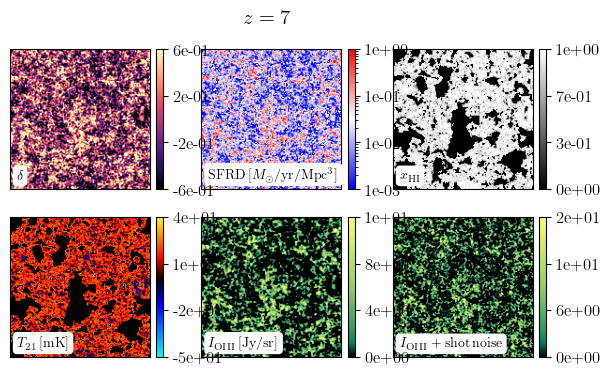

In [ ]:
Lbox_fid = 300 
Nbox_fid = 150 
z = 7.

plot_slices(z, Lbox_fid, Nbox_fid, OIII_model, ClassyC, smooth=True,seed=1605, RSD=1, extralabel='', save_and_import=False)

You can also estimate the auto- and cross- power spectra from the LIM boxes. To do so, we use the publicly available code **powerbox**.

Here we compare the power spectrum, with smoothing, RSD and shot noise obtained analytically and estimated from the box.

In [7]:
import powerbox as pb

In [8]:
Deltak_OIII_analytical = OIII_model.LIM_pk.Deltasq_LIM 

In [9]:
# we introduce a second line, with a different resolution for illustration purposes
CO_model = a.run_oLIMpus('CO21',LINE_MODEL = 'Yang21', _R = 5., shot_noise= True, quadratic_lognormal=True, astromodel=0, ZMIN=5., RSD_MODE=1)

Deltak_CO_analytical = CO_model.LIM_pk.Deltasq_LIM 

In [10]:
# and the cross power spectrum between the two lines -- see tutorial #1 for details
cross_model = a.Power_Spectra_LIM(CO_model.LIM_corr, OIII_model.LIM_coeff, OIII_model.LP, OIII_model.CP, OIII_model.UP, 1,CO_model.LIM_coeff,CO_model.LP)

Deltak_cross_analytical = cross_model.Deltasq_LIM

In [11]:
k_bins = np.logspace(np.log10(2*np.pi/Lbox_fid),np.log10(2*np.pi/Lbox_fid*Nbox_fid),10) # define the k array 
seed = 1 
RSD = 0 

# get boxes for two different line
# doesn't matter which line

reionization_map_partial, ion_frac_withpartial = get_reio_field(OIII_model.zeus_coeff, OIII_model.zeus_corr, OIII_model.AP, OIII_model.CP, ClassyC, OIII_model.HMFcl, Lbox_fid, Nbox_fid, mass_weighted_xHII=True, seed=seed)

box_LIM = get_boxes('LIM', z,  Lbox_fid, Nbox_fid, OIII_model, reionization_map_partial, ion_frac_withpartial, smooth=True, shot_noise=False, ClassyC=ClassyC, RSD=RSD, seed=seed, extralabel='', save_and_import = False)

box_LIM_1 = get_boxes('LIM', z,  Lbox_fid, Nbox_fid, CO_model, reionization_map_partial, ion_frac_withpartial, smooth=True, shot_noise=False, ClassyC=ClassyC, RSD=RSD, seed=seed, extralabel='', save_and_import = False)

# compute the LIM power spectrum 
pk_LIM, k_LIM = pb.get_power(
    deltax = box_LIM,
    boxlength= Lbox_fid,
    bins = k_bins,
    ) 
pk_LIM *= k_LIM**3/2/np.pi**2

# compute the LIM power spectrum for the second line
pk_LIM_1, k_LIM_1 = pb.get_power(
    deltax = box_LIM_1,
    boxlength= Lbox_fid,
    bins = k_bins
    )

pk_LIM_1 *= k_LIM_1**3/2/np.pi**2

# compute the cross power spectrum 
pk_cross, k_cross = pb.get_power(
    deltax = box_LIM,
    boxlength= Lbox_fid,
    deltax2 = box_LIM_1,
    bins = k_bins
    )

pk_cross *= k_cross**3/2/np.pi**2


 60%|██████    | 6/10 [00:00<00:00,  7.84it/s]


SUCCESS: BMF converged in 6 iterations.


100%|██████████| 99/99 [00:23<00:00,  4.15it/s]


The resolution cannot be smaller than R and Lbox/Nbox
Smoothing R changed to 2.0


We compare the auto-power spectra estimated from the boxes with the analytical ones obtained using the effective models of oLIMpus (see tutorial #1).

In the following plot we scale the auto- power spectra by the average mean of each signal. 

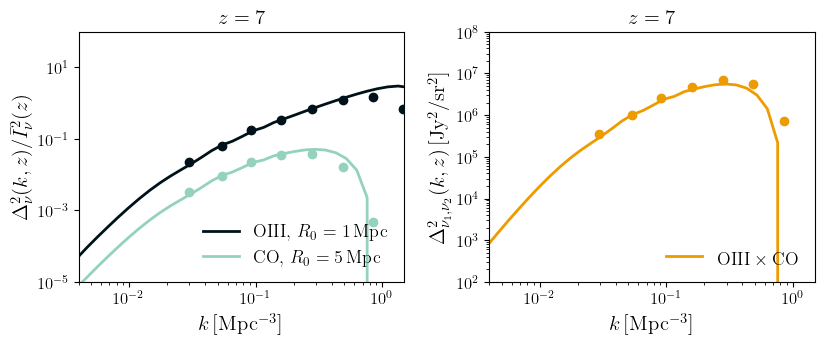

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.7),)

# k array 
klist = OIII_model.LIM_corr._klistCF

# find the closest redshift point in the array that was used in the line pk run 
iz_val = min(range(len(OIII_model.LIM_coeff.zintegral)), key=lambda i: np.abs((OIII_model.LIM_coeff.zintegral[i]-z))) 


axes[0].loglog(klist,Deltak_OIII_analytical[iz_val]/OIII_model.LIM_coeff.Inu_bar[iz_val]**2,color=a.colors[0],label=r'${\rm OIII},\,R_0=%g\,{\rm Mpc}$'%OIII_model.LP._R,)
axes[0].loglog(klist,Deltak_CO_analytical[iz_val]/CO_model.LIM_coeff.Inu_bar[iz_val]**2,color=a.colors[3],label=r'${\rm CO},\,R_0=%g\,{\rm Mpc}$'%CO_model.LP._R,)

axes[0].scatter(k_LIM,pk_LIM/OIII_model.LIM_coeff.Inu_bar[iz_val]**2,color=a.colors[0],marker='o',zorder=8,)
axes[0].scatter(k_LIM_1,pk_LIM_1/CO_model.LIM_coeff.Inu_bar[iz_val]**2,color=a.colors[3],marker='o',zorder=8,)

axes[0].set_ylabel(r'${\Delta^2_{\nu}(k,z)}/{\bar{I}_\nu^2(z)}$',fontsize=15)
axes[0].set_xlabel(r'$k\,[{\rm Mpc^{-3}}]$',fontsize=15)
axes[0].legend(fontsize=13,columnspacing=0.5,loc=4,ncol=1)


axes[1].loglog(klist,Deltak_cross_analytical[iz_val],color=a.colors[5],label=r'${\rm OIII\times CO}$',)

axes[1].scatter(k_cross,pk_cross,color=a.colors[5],marker='o',zorder=8,)

axes[1].set_ylabel(r'$\Delta^2_{\nu_1,\nu_2}(k,z)\,[{\rm Jy^2/sr^2}]$',fontsize=15)
axes[1].set_xlabel(r'$k\,[{\rm Mpc^{-3}}]$',fontsize=15)
axes[1].legend(fontsize=13,columnspacing=0.5,loc=4,ncol=1)

axes[0].set_title(r'$z=%g$'%round(OIII_model.LIM_coeff.zintegral[iz_val],1),fontsize=15)
axes[1].set_title(r'$z=%g$'%round(OIII_model.LIM_coeff.zintegral[iz_val],1),fontsize=15)
axes[0].set_ylim(1e-5,1e2)
axes[1].set_ylim(1e2,1e8)

axes[0].set_xlim(4e-3,1.5)
axes[1].set_xlim(4e-3,1.5)

plt.tight_layout()


## Plot lightcones

oLIMpus produces lightcones by interpolating contiguous slices in adjacent coeval boxes. Lightcones can be produced for each of the quantities introduced in the coeval boxes case. 

The functions to produce and plot the lightcones are defined in the **maps_LIM** module. Note that, when the lightcone is run, coeval boxes are automatically stored.

If the box size and number of cells is too small, the interpolation procedure introduces spurious features in the lightcones; in the following, we show an example of lighcones computed starting from a small box.

In [42]:
from oLIMpus import plot_lightcone

In [ ]:
# box side
Lbox_lightcone = 50
# number of cells
Nbox_lightcone = 50

/mnt/DATA/coding/21cm/oLIMpus/Tutorial/analysis_50,50,1.0/lightconesdensity.pkl
/mnt/DATA/coding/21cm/oLIMpus/Tutorial/analysis_50,50,1.0/lightconesSFRD.pkl
/mnt/DATA/coding/21cm/oLIMpus/Tutorial/analysis_50,50,1.0/lightconesxHI.pkl
/mnt/DATA/coding/21cm/oLIMpus/Tutorial/analysis_50,50,1.0/lightconesT21.pkl
/mnt/DATA/coding/21cm/oLIMpus/Tutorial/analysis_50,50,1.0/lightconesLIMOIII.pkl


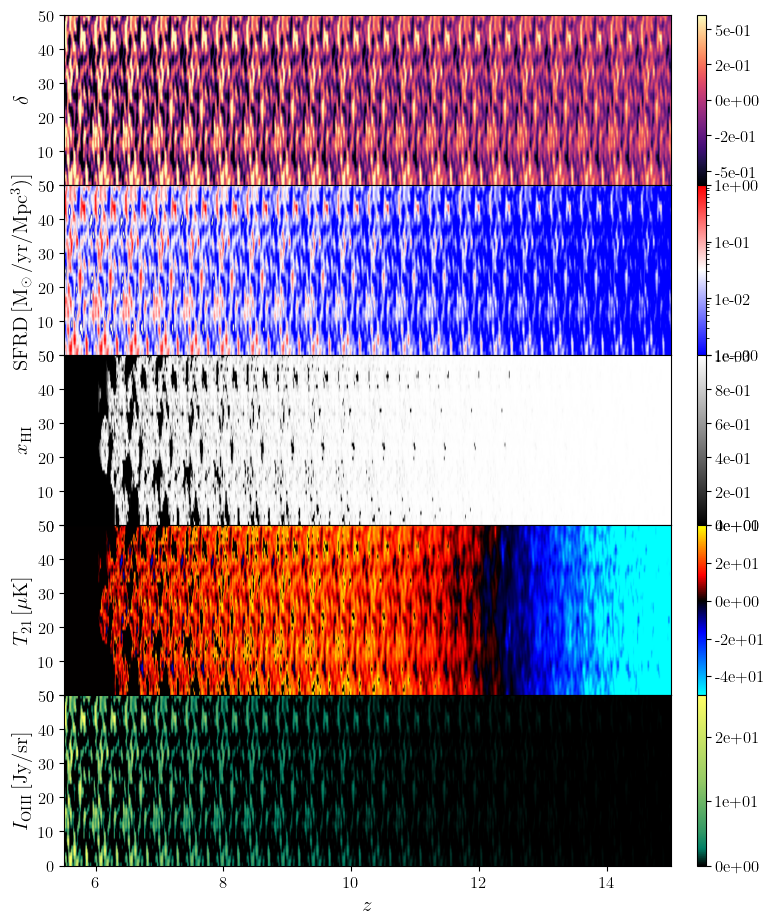

In [43]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(8,9.5),gridspec_kw={'hspace': 0},sharex=True)

# the first time you run these functions, they will store all the coeval boxes! 
plot_lightcone('density', # which lightcone to produce (density, SFRD, xH, T21, LIM - with/without shot noise, with/without smoothing)
        np.logspace(np.log10(5.5),np.log10(15.),100)[::-1], # redshift array used to interpolate the lightcone
        Lbox = Lbox_lightcone, # box side
        Ncell = Nbox_lightcone, # number of cells per side
        R = 1., # resolution R0 (Mpc) 
        seed = 1065, # random seed 
        analytical=True, # True to produce coeval boxes using CoevalBox_LIM_analytical ; False to use CoevalBox_percell ; for the moment, in the T21 case, the brightness temperature power spectrum is computed analytically, while the bubble field is per cell
        correlations_21 = OIII_model.zeus_corr, # zeus21 correlation structure
        coefficients_21 = OIII_model.zeus_coeff, # zeus21 coefficients
        PS21 = OIII_model.zeus_pk, # zeus21 21cm power spectrum
        correlations = OIII_model.LIM_corr, # LIM correlation structure
        coefficients = OIII_model.LIM_coeff, # LIM coefficients
        PSLIM = OIII_model.LIM_pk, # LIM power spectrum
        mass_weighted_xHII=True, # in the xH computation, get the average xH by weighting its value by the mass in the cell
        LineParams = OIII_model.LP, # line parameters
        AstroParams=OIII_model.AP,  # astro parameters
        CosmoParams = OIII_model.CP, # cormo parameters
        HMFintclass = OIII_model.HMFcl, # HMF class
        ClassyCosmo=ClassyC, # CLASS output
        RSD = 1, # choose which RSD 
        fig=fig, # for plotting purposes
        ax=ax[0],# for plotting purposes
)

plot_lightcone('SFRD',
        np.logspace(np.log10(5.5),np.log10(15.),100)[::-1],
        Lbox_lightcone, 
        Nbox_lightcone, 
        1.,
        1065, 
        True, 
        OIII_model.zeus_corr,
        OIII_model.zeus_coeff,
        OIII_model.zeus_pk,
        OIII_model.LIM_corr,
        OIII_model.LIM_coeff,
        OIII_model.LIM_pk,
        True,
        OIII_model.LP,
        OIII_model.AP, 
        OIII_model.CP,
        OIII_model.HMFcl,
        ClassyC,
        1,
        fig=fig,
        ax=ax[1],
)
plot_lightcone('xHI',
        np.logspace(np.log10(5.5),np.log10(15.),100)[::-1],
        Lbox_lightcone, 
        Nbox_lightcone, 
        1.,
        1065, 
        True, 
        OIII_model.zeus_corr,
        OIII_model.zeus_coeff,
        OIII_model.zeus_pk,
        OIII_model.LIM_corr,
        OIII_model.LIM_coeff,
        OIII_model.LIM_pk,
        True,
        OIII_model.LP,
        OIII_model.AP, 
        OIII_model.CP,
        OIII_model.HMFcl,
        ClassyC,
        1,
        fig=fig,
        ax=ax[2],
)
plot_lightcone('T21',
        np.logspace(np.log10(5.5),np.log10(15.),100)[::-1],
        Lbox_lightcone, 
        Nbox_lightcone, 
        1.,
        1065, 
        True, 
        OIII_model.zeus_corr,
        OIII_model.zeus_coeff,
        OIII_model.zeus_pk,
        OIII_model.LIM_corr,
        OIII_model.LIM_coeff,
        OIII_model.LIM_pk,
        True,
        OIII_model.LP,
        OIII_model.AP, 
        OIII_model.CP,
        OIII_model.HMFcl,
        ClassyC,
        1,
        fig=fig,
        ax=ax[3],
)

plot_lightcone('LIM',
        np.logspace(np.log10(5.5),np.log10(15.),100)[::-1],
        Lbox_lightcone, 
        Nbox_lightcone, 
        1.,
        1065, 
        True, 
        OIII_model.zeus_corr,
        OIII_model.zeus_coeff,
        OIII_model.zeus_pk,
        OIII_model.LIM_corr,
        OIII_model.LIM_coeff,
        OIII_model.LIM_pk,
        True,
        OIII_model.LP,
        OIII_model.AP, 
        OIII_model.CP,
        OIII_model.HMFcl,
        ClassyC,
        1,
        fig=fig,
        ax=ax[4],
        include_label = 'OIII'
)


plt.tight_layout(h_pad=0.1)
plt.savefig('./lightcones_' + str(Lbox_lightcone) + ',' + str(Nbox_lightcone) + '.png',dpi=500,bbox_inches='tight')#,transparent=True)


For further information, the user can refer to the documentation of each module, or contact the author at:

libanore@bgu.ac.il